# Visualizing Barren Plateaus
[Sauce](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [42]:
# !pip install -q qiskit pylatexenc
# !pip install -q git+https://github.com/Gopal-Dahale/qiskit-qulacs.git

In [43]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [44]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

In [45]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = 4)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [46]:
estimator = Estimator()

In [47]:
def generate_random_pqc(n_qubits, n_layers):

    qc = QuantumCircuit(n_qubits)

    theta, phi = Parameter('θ'), Parameter('φ')

    for q in range(n_qubits):
        qc.ry(np.pi / 4, q)

    qc.barrier()

    for l in range(n_layers):

        for q in range(n_qubits):

            if l == 0:
                val = theta
            elif l == 1:
                val = phi
            else:
                val = np.random.uniform(0, 2 * np.pi)

            num = np.random.randint(3)

            if l % 3 == 0:
                qc.rx(val, q)
            elif l % 3 == 1:
                qc.ry(val, q)
            else:
                qc.rz(val, q)

        for q in range(0, n_qubits - 1, 2):
            qc.cz(q, q + 1)
        for q in range(1, n_qubits - 1, 2):
            qc.cz(q, q + 1)

        qc.barrier()

    return qc

/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-orAwPlel/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


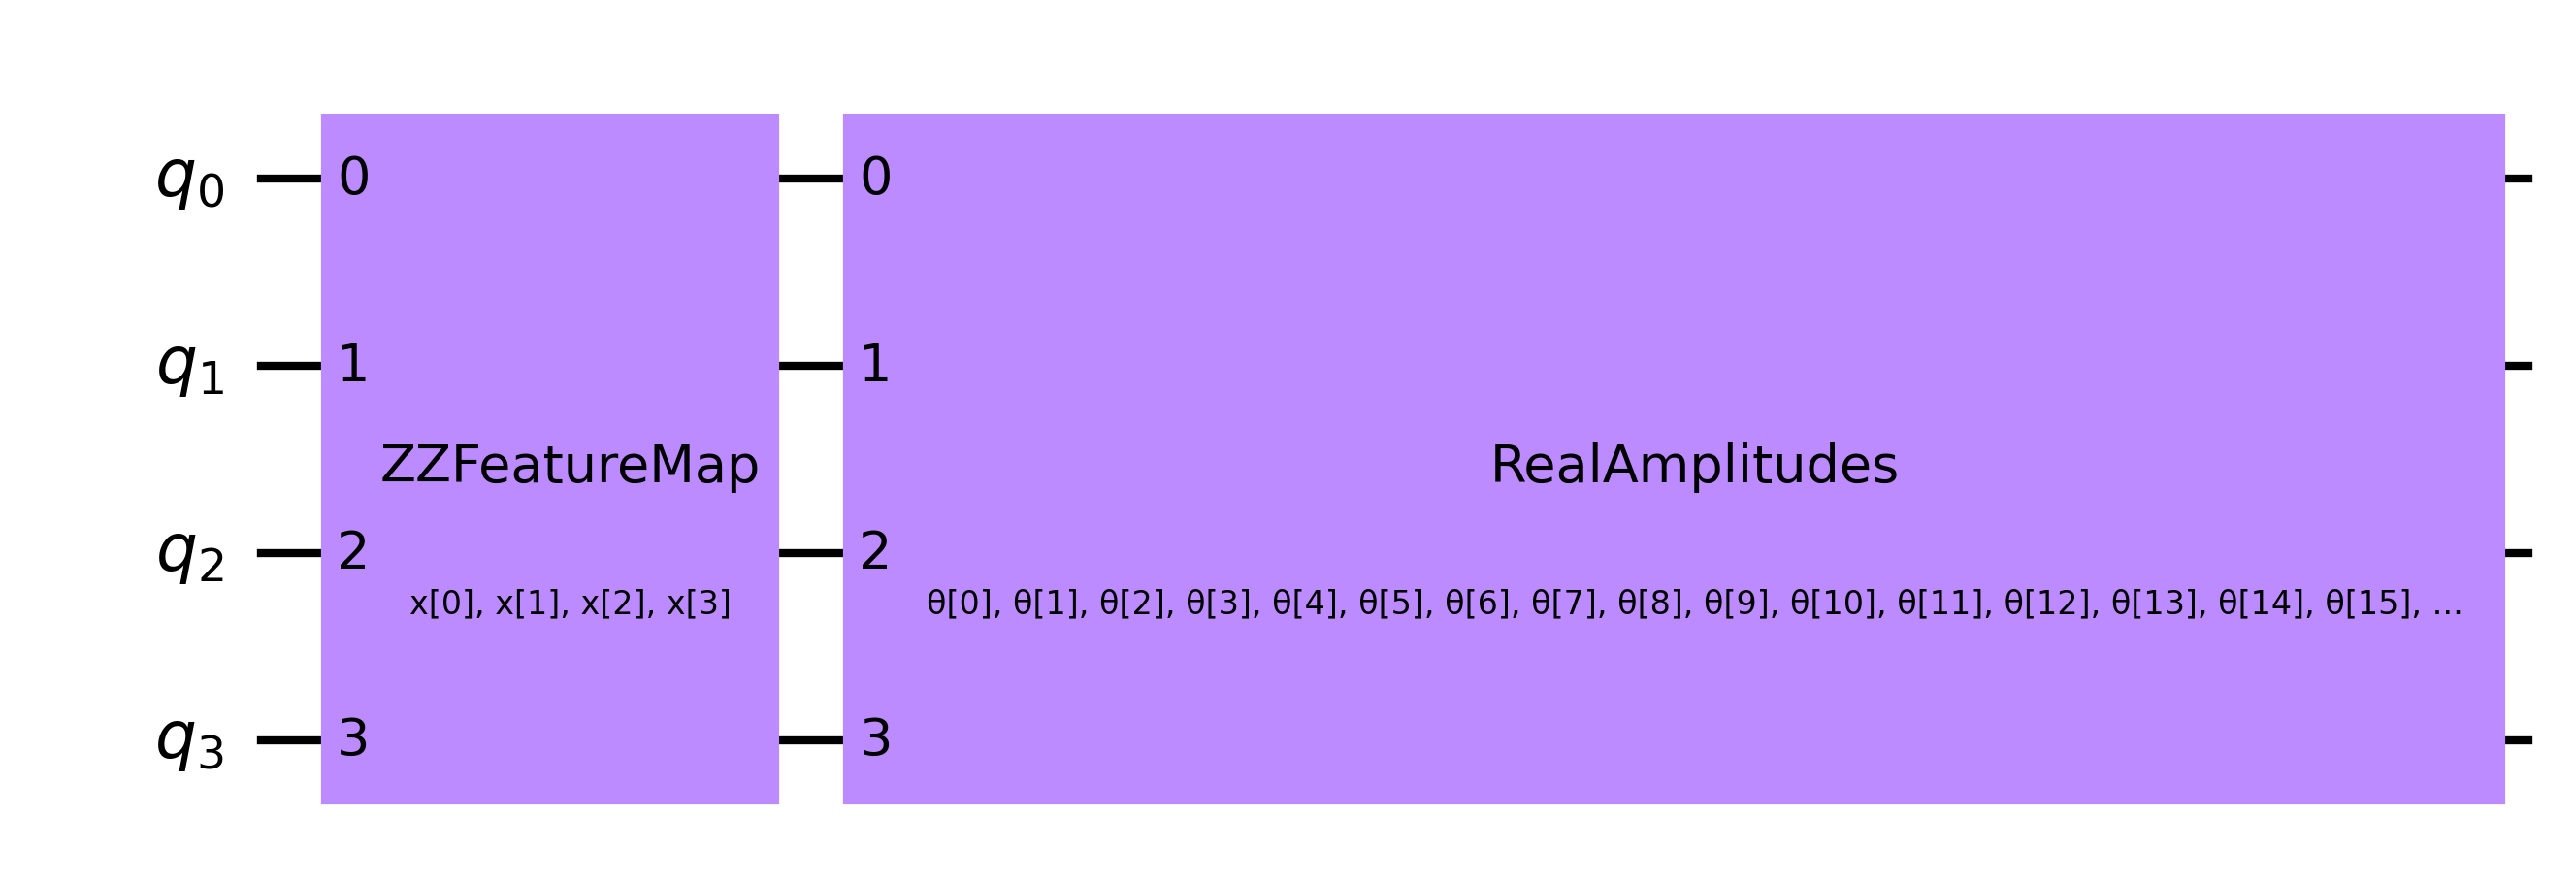

In [48]:
feature_map = featureMapGenerator(4)
ansatz = AnsatzGenerator(4, 4, ENTANGLEMENT)

qc = circuitBuilder(feature_map, ansatz, 'middle')
qc.draw('mpl')

In [49]:
randompoint = np.random.uniform(0, np.pi/2, ansatz.num_parameters)

In [56]:
# print('randompoint = ', randompoint)
# X = np.arange(-np.pi, np.pi, 0.25)
# Y = np.arange(-np.pi, np.pi, 0.25)
# X, Y = np.meshgrid(X, Y)
# for x in X[0, :]:
#     for y in Y[:, 0]:
#         rotations = np.array([x, y])
#         print(rotations)

res = []
GLOBAL_OPERATOR = SparsePauliOp.from_list([('Z'*qc.num_qubits, 1)])
for i in [0, 1, 2]:
    initial_point = np.random.uniform(0, np.pi/2, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        1, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res.append([initial_point, losses[0].numpy()])


Epoch      Loss                 Train Accuracy   Test Accuracy   
[ 0 ]      0.9035099744796753   0.59799          0.64327         
Epoch      Loss                 Train Accuracy   Test Accuracy   
[ 0 ]      1.0155199766159058   0.46985          0.46199         
Epoch      Loss                 Train Accuracy   Test Accuracy   
[ 0 ]      0.970009982585907    0.54271          0.50877         


In [57]:
res

[[array([0.80374105, 0.83584191, 0.1683454 , 0.7027937 , 0.83663325,
         0.38087178, 0.42292628, 0.59263658, 0.03152776, 0.50592077,
         0.33214175, 0.51443164, 0.18812192, 1.39883698, 0.93241285,
         1.06673143, 1.23962728, 0.78295118, 0.13653407, 0.84368498]),
  array(0.90351117, dtype=float32)],
 [array([0.92180787, 1.17093359, 0.67804923, 0.20040267, 0.44575415,
         0.57032834, 1.01460443, 0.89657646, 0.55935543, 1.54961453,
         0.95154886, 0.37263497, 0.15987953, 0.24011057, 0.3863495 ,
         0.25239771, 0.2930588 , 0.44782644, 0.27233461, 1.40863583]),
  array(1.01552, dtype=float32)],
 [array([0.12603087, 0.82390056, 0.64464983, 1.54311672, 0.1759903 ,
         0.62495011, 1.5228406 , 1.35953541, 1.28345381, 0.40511281,
         0.26842959, 1.05030231, 1.45986039, 0.87456111, 0.89788711,
         0.43979013, 1.20871667, 0.29380763, 0.50843416, 0.668274  ]),
  array(0.9700105, dtype=float32)]]

In [61]:
pd.DataFrame(res).to_csv('./bp-visualise/point-mae.csv')

/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-orAwPlel/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


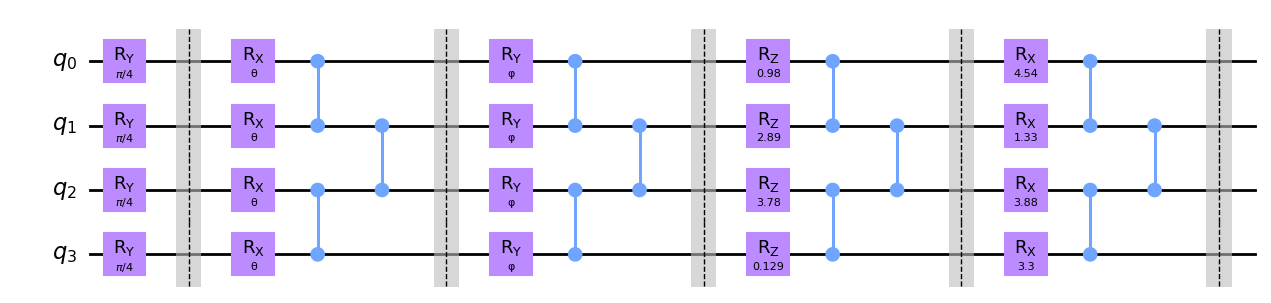

In [12]:
circ = generate_random_pqc(4, 4)
circ.draw('mpl')

In [6]:
def generate_surface(circuit, observable):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = np.array([x, y])
            Z_assembler.append(
                estimator.run(circuit, observable,
                              rotations).result().values[0])
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z


def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X,
                           Y,
                           surface,
                           rstride=1,
                           cstride=1,
                           cmap=plt.get_cmap('rainbow'),
                           linewidth=0,
                           antialiased=False,
                           alpha=0.6)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('θ')
    ax.set_ylabel('φ')
    ax.set_zlabel('Pauli-Z Expectation')
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()

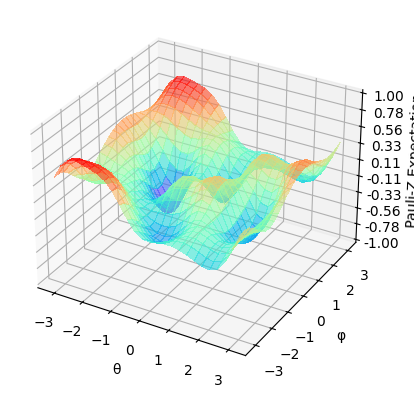

In [7]:
n_qubits = 4
n_layers = 50
op = SparsePauliOp(['I' * (n_qubits - 2) + 'ZZ'])

small_qubit_qc = generate_random_pqc(n_qubits, n_layers)

small_global_surface = generate_surface(small_qubit_qc, op)
plot_surface(small_global_surface)

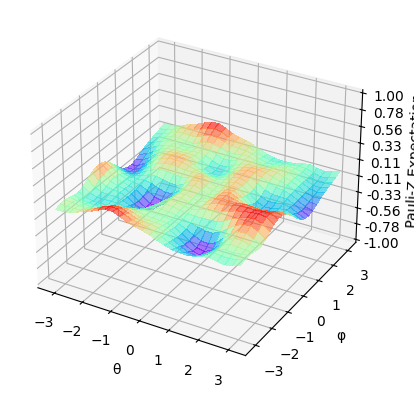

In [8]:
n_qubits = 12
n_layers = 50
op = SparsePauliOp(['I' * (n_qubits - 2) + 'ZZ'])

large_qubit_qc = generate_random_pqc(n_qubits, n_layers)

large_global_surface = generate_surface(large_qubit_qc, op)
plot_surface(large_global_surface)

In [9]:
# precede the number with zeros, creating a thong of a certain length
def makeIndexOfLength(index, length):
    indexStr = str(index)
    return ('0' * (length - len(indexStr)) + indexStr)

In [10]:
X = np.arange(-np.pi, np.pi, 0.25)
Y = np.arange(-np.pi, np.pi, 0.25)
X, Y = np.meshgrid(X, Y)

In [11]:
OUTPUT_DIR = "gradient_descent_small"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for angle in range(0, 180):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(X,
                           Y,
                           small_global_surface,
                           rstride=1,
                           cstride=1,
                           cmap=plt.get_cmap('rainbow'),
                           linewidth=0,
                           antialiased=False,
                           alpha=0.6)

    ax.set_title("4 qubit, 50 layers circuit")
    ax.set_zlim(-1, 1)
    ax.set_xlabel('θ')
    ax.set_ylabel('φ')
    ax.set_zlabel('Pauli-Z Expectation')
    ax.view_init(30 + (90 - angle) / 5, 45 + angle * 2)
    plt.savefig("./" + OUTPUT_DIR + "/" + makeIndexOfLength(angle, 3) + ".png")
    plt.close()

In [14]:
OUTPUT_DIR = "gradient_descent_large"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for angle in range(0, 180):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(X,
                           Y,
                           large_global_surface,
                           rstride=1,
                           cstride=1,
                           cmap=plt.get_cmap('rainbow'),
                           linewidth=0,
                           antialiased=False,
                           alpha=0.6)

    ax.set_title("12 qubit, 50 layers circuit")
    ax.set_zlim(-1, 1)
    ax.set_xlabel('θ')
    ax.set_ylabel('φ')
    ax.set_zlabel('Pauli-Z Expectation')
    ax.view_init(30 + (90 - angle) / 5, 45 + angle * 2)
    plt.savefig("./" + OUTPUT_DIR + "/" + makeIndexOfLength(angle, 3) + ".png")
    plt.close()